In [1]:
import gc
gc.collect()

35

### Table of Contents
    01. Import libraries
        a. Import dataset
        b. Create a sample subset
    02. Security Implications
    03. Regional Segmentation
    04. Exclusion Flag for Low-Activity Customers
    05. Customer profiling
        a. Age
        b. Income
        c. Number of dependents
        d. Pet status 
        e. Baby status 
        f. Alcohol status 
    06. Aggregating values based on profiling (min, max, mean)
        a. Age
        b. Income
        c. Pet status
        d. Baby status
        e. Alcohol status
    07. Creating visualizations to show the distribution of profiles
        a. Products and busiest times of the day/week
        b. Analysis of customer profiling
    08. Exporting visualizations

# 01. Import libraries

In [2]:
# import libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

In [3]:
# Create a path for easier importing
path = r'C:\Users\blim9\Desktop\Career Foundry\Data Immersion\Achievement 4\Instacart Basket Analysis'

In [4]:
# Import the last dataset worked on 
df_merged = pd.read_pickle(os.path.join (path, '02 Data', 'Prepared Data', 'final_dataframe.pkl'))

In [5]:
df_merged.head()

,order_id,user_id,order_number,order_day_of_week,order_hour_of_day,days_since_last_order,new_customer,product_id,add_to_cart_order,reordered,...,order_frequency_flag,first_name,last_name,gender,state,age,date_joined,num_of_dependants,fam_status,income
0,2539329,1,1,2,8,NaN,True,196,1,0,...,Non-frequent customer,Linda,Nguyen,Female,Alabama,31,2/17/2019,3,married,40423
1,2398795,1,2,3,7,15.0,False,196,1,1,...,Non-frequent customer,Linda,Nguyen,Female,Alabama,31,2/17/2019,3,married,40423
2,473747,1,3,3,12,21.0,False,196,1,1,...,Non-frequent customer,Linda,Nguyen,Female,Alabama,31,2/17/2019,3,married,40423
3,2254736,1,4,4,7,29.0,False,196,1,1,...,Non-frequent customer,Linda,Nguyen,Female,Alabama,31,2/17/2019,3,married,40423
4,431534,1,5,4,15,28.0,False,196,1,1,...,Non-frequent customer,Linda,Nguyen,Female,Alabama,31,2/17/2019,3,married,40423


### For the purpose of this project, I will be creating a sample subset with a 70/30 split. The 30 percent sample will resemble the 70 percent sample.

In [6]:
# Create a random list of floating numbers
np.random.seed(4)

In [7]:
split = np.random.rand(len(df_merged)) <= 0.7

In [8]:
# Split the dataframe into two samples
df_big = df_merged[split]
df_subset = df_merged[~split]

In [9]:
# Check how many rows the original dataframe has
len(df_merged)

32404859

In [10]:
# Check that both the length of the two dataframes adds up to the above number
len(df_big) + len(df_subset)

32404859

# 02. Security implications

In [11]:
df_subset.columns

Index(['order_id', 'user_id', 'order_number', 'order_day_of_week',
       'order_hour_of_day', 'days_since_last_order', 'new_customer',
       'product_id', 'add_to_cart_order', 'reordered', 'product_name',
       'aisle_id', 'department_id', 'prices', '_merge', 'prices_range_label',
       'busiest_day', 'busiest_days', 'busiest_period_of_day', 'max_order',
       'loyalty_flag', 'avg_price', 'spending_flag', 'median_last_order',
       'order_frequency_flag', 'first_name', 'last_name', 'gender', 'state',
       'age', 'date_joined', 'num_of_dependants', 'fam_status', 'income'],
      dtype='object')

#### The two columns that have PII (personally identifiable information) are first_name and last_name

In [12]:
# Drop the two PII columns as well as the _merge column as it will not serve any purpose
df_subset = df_subset.drop(columns = ['first_name', 'last_name', '_merge'])

In [13]:
# Check that the columns were dropped (should be 31 rows)
df_subset.shape

(9721098, 31)

# 03. Regional segmentation

#### I will be using the new dataframe with the three removed columns

In [14]:
# Create lists for each region based on this article: https://simple.wikipedia.org/wiki/List_of_regions_of_the_United_States
Northeast = ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 
             'New York', 'Pennsylvania', 'New Jersey']
Midwest = ['Wisconsin', 'Michigan', 'Illinois', 'Indiana', 'Ohio', 'North Dakota', 'South Dakota', 
           'Nebraska', 'Kansas', 'Minnesota', 'Iowa', 'Missouri']
South = ['Delaware', 'Maryland', 'District of Columbia', 'Virginia', 'West Virginia', 'North Carolina', 
         'South Carolina', 'Georgia', 'Florida', 'Kentucky', 'Tennessee', 'Mississippi', 'Alabama', 
         'Oklahoma', 'Texas', 'Arkansas', 'Louisiana']
West = ['Idaho', 'Montana', 'Wyoming', 'Nevada', 'Utah', 'Colorado', 'Arizona', 'New Mexico', 'Alaska', 
        'Washington', 'Oregon', 'California', 'Hawaii']

In [15]:
# Create the 'region' column based on the 'state' column
df_subset.loc[df_subset['state'].isin(Northeast), 'region'] = 'Northeast'

In [16]:
df_subset.loc[df_subset['state'].isin(Midwest), 'region'] = 'Midwest'

In [17]:
df_subset.loc[df_subset['state'].isin(South), 'region'] = 'South'

In [18]:
df_subset.loc[df_subset['state'].isin(West), 'region'] = 'West'

In [19]:
# Create a crosstab to identify the spending habits between the U.S. regions
crosstab = pd.crosstab(df_subset['region'], df_subset['spending_flag'], dropna = False)

In [20]:
crosstab

spending_flag,High spender,Low spender
region,,
Midwest,46352,2231799
Northeast,32401,1682946
South,62680,3175953
West,48232,2440735


#### Based on the observations above, the crosstab shows that the Southern region has both the largest number of both High spenders and Low spenders. On the contrary, the Northeastern region has the smallest number of both High spenders and Low spenders.

In [21]:
crosstab2 = pd.crosstab(df_subset['region'], df_subset['loyalty_flag'], dropna = False)

In [22]:
crosstab2

loyalty_flag,Loyal customer,New customer,Regular customer
region,,,
Midwest,712176,441703,1124272
Northeast,550677,330482,834188
South,1021253,623345,1594035
West,799467,479363,1210137


#### The Southern region once against reigns supreme in terms of numbers. In all three categories, they have the highest number of customers. This could play a major part in that the Southern region has a larger population with the most number of states included. The Northeastern region also has the lowest number compared to the other regions, indicating it may have the lowest total population.

In [23]:
df_subset.groupby('region').agg({'avg_price': 'mean'})

,avg_price
region,
Midwest,12.693609
Northeast,11.531572
South,12.199883
West,11.307486


#### In terms of average price spent by region, there isn't a large difference despite the population. The Southern region spent an average of 12.20 while the Midwestern region spent an average of 12.69. The Northeastern region despite having the lowest numbers above, do not have the lowest average price.

# 04. Exclusion flags for low-activity customers

In [24]:
# Create an exclusion flag for customers with less than 5 orders and exclude them from the data
df_subset.loc[df_subset['max_order'] < 5, 'activity_flag'] = 'Low activity'
df_subset.loc[df_subset['max_order'] >= 5, 'activity_flag'] = 'Regular to high activity'

In [25]:
df_subset['activity_flag'].value_counts(dropna = False)

Regular to high activity    9288753
Low activity                 432345
Name: activity_flag, dtype: int64

In [26]:
# Create a new dataframe to hold the low-activity customers
df_low = df_subset.loc[df_subset['activity_flag'] == 'Low activity']

In [27]:
# Check that it has values
df_low.head()

,order_id,user_id,order_number,order_day_of_week,order_hour_of_day,days_since_last_order,new_customer,product_id,add_to_cart_order,reordered,...,order_frequency_flag,gender,state,age,date_joined,num_of_dependants,fam_status,income,region,activity_flag
3856,3046940,360,2,2,8,4.0,False,5322,3,0,...,Frequent customer,Male,Arizona,46,9/1/2017,1,married,104257,West,Low activity
3859,2300993,360,3,1,13,6.0,False,28155,3,0,...,Frequent customer,Male,Arizona,46,9/1/2017,1,married,104257,West,Low activity
3866,3226575,360,1,5,12,NaN,True,3039,4,0,...,Frequent customer,Male,Arizona,46,9/1/2017,1,married,104257,West,Low activity
3868,3046940,360,2,2,8,4.0,False,19376,2,0,...,Frequent customer,Male,Arizona,46,9/1/2017,1,married,104257,West,Low activity
3870,2300993,360,3,1,13,6.0,False,31716,4,0,...,Frequent customer,Male,Arizona,46,9/1/2017,1,married,104257,West,Low activity


In [28]:
# Export the low-activity customer dataframe
df_low.to_pickle(os.path.join (path, '02 Data', 'Prepared Data', 'low_activity_customers.pkl'))

In [29]:
# Delete df_low to reduce memory 
del df_low

In [30]:
# Create a new dataframe to hold alL the remaining customers with regular to high activity
df_current = df_subset.loc[df_subset['activity_flag'] == 'Regular to high activity']

In [31]:
df_current.head()

,order_id,user_id,order_number,order_day_of_week,order_hour_of_day,days_since_last_order,new_customer,product_id,add_to_cart_order,reordered,...,order_frequency_flag,gender,state,age,date_joined,num_of_dependants,fam_status,income,region,activity_flag
0,2539329,1,1,2,8,NaN,True,196,1,0,...,Non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423,South,Regular to high activity
2,473747,1,3,3,12,21.0,False,196,1,1,...,Non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423,South,Regular to high activity
3,2254736,1,4,4,7,29.0,False,196,1,1,...,Non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423,South,Regular to high activity
6,550135,1,7,1,9,20.0,False,196,1,1,...,Non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423,South,Regular to high activity
10,2539329,1,1,2,8,NaN,True,14084,2,0,...,Non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423,South,Regular to high activity


# 05. Customer profiling

#### Create profiles based on factors such as age, income, certain goods in the 'department_id' column, and number of dependents

### Age Profile

In [32]:
# Create a profile based on age. It will be split up between three categories: Young adult, Middle aged, Senior or elderly
df_current.loc[df_current['age'] <= 35, 'age_group'] = 'Young adult'
df_current.loc[(df_current['age'] > 35) & (df_current['age'] <= 55), 'age_group'] = 'Middle aged'
df_current.loc[df_current['age'] > 55, 'age_group'] = 'Senior or elderly'

C:\Users\blim9\AppData\Local\Temp\ipykernel_3120\2298736874.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_current.loc[df_current['age'] <= 35, 'age_group'] = 'Young adult'


In [33]:
df_current['age_group'].value_counts(dropna = False)

Senior or elderly    3751663
Middle aged          2915074
Young adult          2622016
Name: age_group, dtype: int64

### Income Profile

In [34]:
# Create a profile based on income. It will be split up between three categories: Low income, Middle income, High income
df_current.loc[df_current['income'] <= 55000, 'income_level'] = 'Low income'
df_current.loc[(df_current['income'] > 55000) & (df_current['income'] <= 140000), 'income_level'] = 'Middle income'
df_current.loc[df_current['income'] > 140000, 'income_level'] = 'High income'

C:\Users\blim9\AppData\Local\Temp\ipykernel_3120\2061231513.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_current.loc[df_current['income'] <= 55000, 'income_level'] = 'Low income'


In [35]:
df_current['income_level'].value_counts(dropna = False)

Middle income    6262542
High income      1691022
Low income       1335189
Name: income_level, dtype: int64

### Number of dependents profile

In [36]:
# Create a profile based on the number of dependents. It will be split up between two categories: True or False
df_current.loc[df_current['num_of_dependants'] > 0, 'has_dependents'] = 'True'
df_current.loc[df_current['num_of_dependants'] == 0, 'has_dependents'] = 'False'

C:\Users\blim9\AppData\Local\Temp\ipykernel_3120\3252445815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_current.loc[df_current['num_of_dependants'] > 0, 'has_dependents'] = 'True'


In [37]:
df_current['has_dependents'].value_counts(dropna = False)

True     6968455
False    2320298
Name: has_dependents, dtype: int64

### Purchased goods profile

In [38]:
# Import the departments_wrangled csv file to cross reference and use as a data dictionary
dept = pd.read_csv(os.path.join (path, '02 Data', 'Prepared Data', 'departments_wrangled.csv'), index_col = False)

In [39]:
# Create a data dictionary
dept_zip = zip(dept['Unnamed: 0'], dept['department'])

In [40]:
data_dict = dict(dept_zip)

In [41]:
data_dict

{1: 'frozen',
 2: 'other',
 3: 'bakery',
 4: 'produce',
 5: 'alcohol',
 6: 'international',
 7: 'beverages',
 8: 'pets',
 9: 'dry goods pasta',
 10: 'bulk',
 11: 'personal care',
 12: 'meat seafood',
 13: 'pantry',
 14: 'breakfast',
 15: 'canned goods',
 16: 'dairy eggs',
 17: 'household',
 18: 'babies',
 19: 'snacks',
 20: 'deli',
 21: 'missing'}

In [42]:
# Map the departmental purchases to the department_id
df_current['category_purchases'] = df_current['department_id'].map(data_dict)

C:\Users\blim9\AppData\Local\Temp\ipykernel_3120\3981060998.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_current['category_purchases'] = df_current['department_id'].map(data_dict)


In [43]:
df_current.head()

,order_id,user_id,order_number,order_day_of_week,order_hour_of_day,days_since_last_order,new_customer,product_id,add_to_cart_order,reordered,...,date_joined,num_of_dependants,fam_status,income,region,activity_flag,age_group,income_level,has_dependents,category_purchases
0,2539329,1,1,2,8,NaN,True,196,1,0,...,2/17/2019,3,married,40423,South,Regular to high activity,Young adult,Low income,True,beverages
2,473747,1,3,3,12,21.0,False,196,1,1,...,2/17/2019,3,married,40423,South,Regular to high activity,Young adult,Low income,True,beverages
3,2254736,1,4,4,7,29.0,False,196,1,1,...,2/17/2019,3,married,40423,South,Regular to high activity,Young adult,Low income,True,beverages
6,550135,1,7,1,9,20.0,False,196,1,1,...,2/17/2019,3,married,40423,South,Regular to high activity,Young adult,Low income,True,beverages
10,2539329,1,1,2,8,NaN,True,14084,2,0,...,2/17/2019,3,married,40423,South,Regular to high activity,Young adult,Low income,True,dairy eggs


#### Pet status profile

In [44]:
# Create a pet owners flag where if they bought pet products, it's (1) and if not, then (0) like boolean values True/False
df_current['pet_owners'] = [1 if x == 'pets' else 0 for x in df_current['category_purchases']]
df_current['pet_owners']=df_current.groupby(['user_id'])['pet_owners'].transform(np.max)
df_current['pet_owners'].value_counts(dropna = False)

C:\Users\blim9\AppData\Local\Temp\ipykernel_3120\4197929637.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_current['pet_owners'] = [1 if x == 'pets' else 0 for x in df_current['category_purchases']]
C:\Users\blim9\AppData\Local\Temp\ipykernel_3120\4197929637.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_current['pet_owners']=df_current.groupby(['user_id'])['pet_owners'].transform(np.max)


0    8586744
1     702009
Name: pet_owners, dtype: int64

#### Baby status profile

In [45]:
# Create a new parents flag where if they bought baby products, it's (1) and if not, then (0) like boolean values True/False
df_current['baby_status'] = [1 if x == 'babies' else 0 for x in df_current['category_purchases']]
df_current['baby_status']=df_current.groupby(['user_id'])['baby_status'].transform(np.max)
df_current['baby_status'].value_counts(dropna = False)

C:\Users\blim9\AppData\Local\Temp\ipykernel_3120\894456639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_current['baby_status'] = [1 if x == 'babies' else 0 for x in df_current['category_purchases']]
C:\Users\blim9\AppData\Local\Temp\ipykernel_3120\894456639.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_current['baby_status']=df_current.groupby(['user_id'])['baby_status'].transform(np.max)


0    7023318
1    2265435
Name: baby_status, dtype: int64

#### Alcohol status profile

In [46]:
# Create a alcohol drinker flag where if they bought alcoholic beverages, it's (1) and if not, then (0) like boolean values True/False
df_current['alcohol_status'] = [1 if x == 'alcohol' else 0 for x in df_current['category_purchases']]
df_current['alcohol_status']=df_current.groupby(['user_id'])['alcohol_status'].transform(np.max)
df_current['alcohol_status'].value_counts(dropna = False)

C:\Users\blim9\AppData\Local\Temp\ipykernel_3120\1782701243.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_current['alcohol_status'] = [1 if x == 'alcohol' else 0 for x in df_current['category_purchases']]
C:\Users\blim9\AppData\Local\Temp\ipykernel_3120\1782701243.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_current['alcohol_status']=df_current.groupby(['user_id'])['alcohol_status'].transform(np.max)


0    8758198
1     530555
Name: alcohol_status, dtype: int64

# 06. Aggregate the min, max, mean variables for usage frequency and expenditure

### Age Profile

In [47]:
# Aggregate the max, mean, and min for the AGE profile
df_current.groupby('age_group').agg({'prices': ['min', 'max', 'mean']})

prices                
                     min   max      mean
age_group                               
Middle aged          1.0  25.0  7.785408
Senior or elderly    1.0  25.0  7.796429
Young adult          1.0  25.0  7.782211

### Income Profile

In [48]:
# Aggregate the max, mean, and min for the INCOME profile
df_current.groupby('income_level').agg({'income': ['min', 'max', 'mean']})

income                       
                  min     max           mean
income_level                                
High income    140001  593901  162565.393762
Low income      25903   54999   43006.003461
Middle income   55001  139998   94764.480611

### Pet owners Profile

In [49]:
# Create a subset of customers who have pets
df_pets = df_current.loc[df_current['category_purchases'] == 'pets']

In [50]:
# Aggregate the max, mean, and min for the PETS profile
df_pets.groupby('category_purchases').agg({'prices': ['min', 'max', 'mean']})

prices                
                      min   max      mean
category_purchases                       
pets                  1.0  15.0  7.875008

### New parents Profile

In [51]:
# Create a subset of customers who bought baby products indicating they may be new parents
df_babies = df_current.loc[df_current['category_purchases'] == 'babies']

In [52]:
# Aggregate the max, mean, and min for the BABIES profile
df_babies.groupby('category_purchases').agg({'prices': ['min', 'max', 'mean']})

prices                
                      min   max      mean
category_purchases                       
babies                1.0  15.0  7.638249

### Alcohol drinkers Profile

In [53]:
# Create a subset of customers who like to drink alcohol
df_alcohol = df_current.loc[df_current['category_purchases'] == 'alcohol']

In [54]:
# Aggregate the max, mean, and min for the ALCOHOL profile
df_alcohol.groupby('category_purchases').agg({'prices': ['min', 'max', 'mean']})

prices                
                      min   max      mean
category_purchases                       
alcohol               1.0  15.0  8.164246

# 07. Create appropriate visualizations to show the distribution of profiles

## *Products and busiest times of the day/week*

### Busiest hour of the day

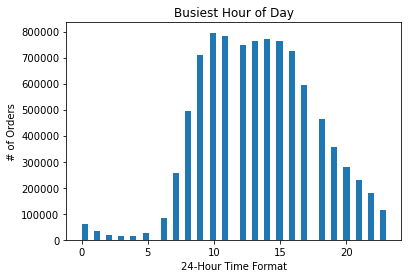

In [65]:
# Create a histogram of the order_hour_of_day column
order_hod_hist = df_current['order_hour_of_day'].plot.hist(bins = 50)
plt.title('Busiest Hour of Day')
plt.xlabel('24-Hour Time Format')
plt.ylabel('# of Orders')
plt.show()

In [60]:
# Create a subset of the df_current to only hold two columns, order_hour_of_day and price
df_current_subset = df_current[['order_hour_of_day', 'prices']]

In [61]:
df_current_subset.head()

,order_hour_of_day,prices
0,8,9.0
2,12,9.0
3,7,9.0
6,9,9.0
10,8,12.5


Text(0, 0.5, 'Average price')

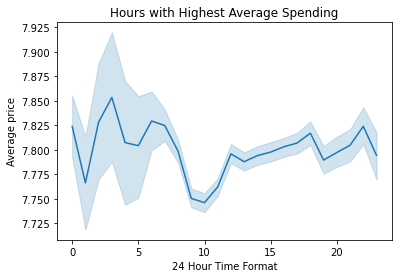

In [67]:
# Create a line graph of the order_hour_of_day column and price column to see which hours have the highest prices
hour_price_line = sns.lineplot(data = df_current_subset, x = 'order_hour_of_day', y = 'prices')
plt.title('Hours with Highest Average Spending')
plt.xlabel('24 Hour Time Format')
plt.ylabel('Average price')

### Busiest day of the week

In [68]:
# Because the order_day_of_week column is of type int8, we will change it to type str
df_order_str = df_current['order_day_of_week'].astype('str')

In [69]:
df_order_str.value_counts()

0    1773440
1    1622224
6    1287354
5    1210034
2    1207258
3    1101020
4    1087423
Name: order_day_of_week, dtype: int64

In [70]:
# Replace the numerical values with its corresponding day values 
df_order_str.replace({"0": "Saturday", "1": "Sunday", "2": "Monday", "3": "Tuesday", "4": "Wednesday", "5": "Thursday", "6": "Friday"}, inplace=True)

In [71]:
df_order_str.value_counts()

Saturday     1773440
Sunday       1622224
Friday       1287354
Thursday     1210034
Monday       1207258
Tuesday      1101020
Wednesday    1087423
Name: order_day_of_week, dtype: int64

Text(0, 0.5, '# of Orders')

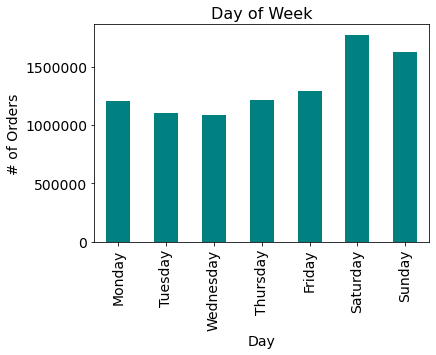

In [72]:
# Create a bar chart for the order_day_of_week column
order_dow_bar = df_order_str.value_counts().loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].plot.bar(color='teal')
plt.title('Day of Week', fontdict = {'fontsize': 16})

plt.ticklabel_format(style='plain', axis='y')
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)

plt.xlabel('Day', fontdict = {'fontsize': 14})
plt.ylabel('# of Orders', fontdict = {'fontsize': 14})


### Popular departmental sales

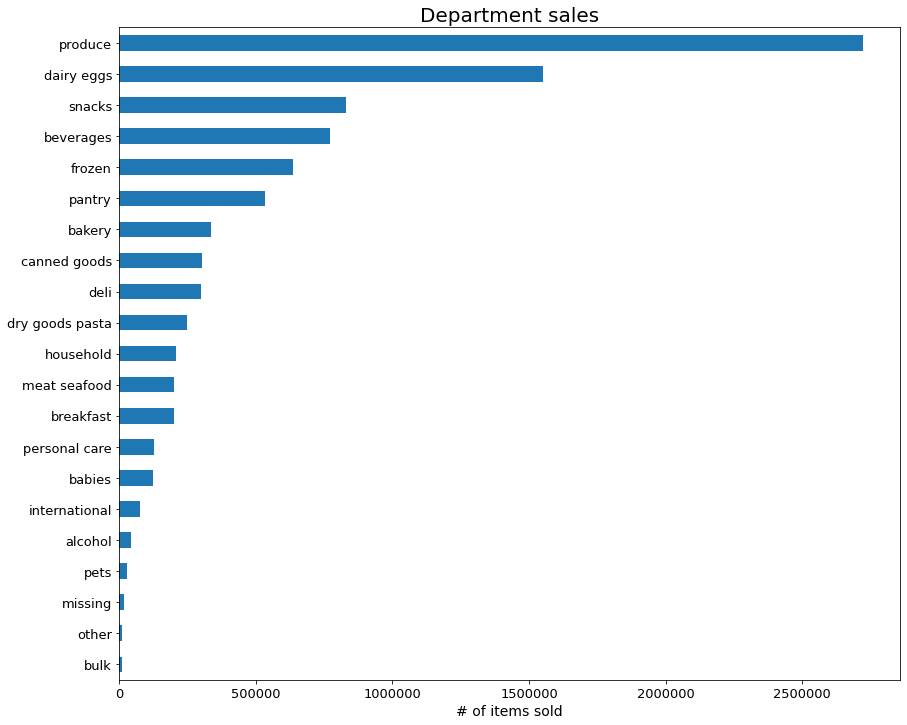

In [73]:
# Create a horizontal bar chart for the departmental purchases
dept_bar = df_current['category_purchases'].value_counts().sort_values().plot.barh(fontsize=13, figsize=[14,12])
plt.title('Department sales', fontdict = {'fontsize': 20})
plt.ticklabel_format(style='plain', axis='x')
plt.xlabel('# of items sold', fontdict = {'fontsize': 14})
plt.show()

## *Analysis of customer profiling*

### Age profile

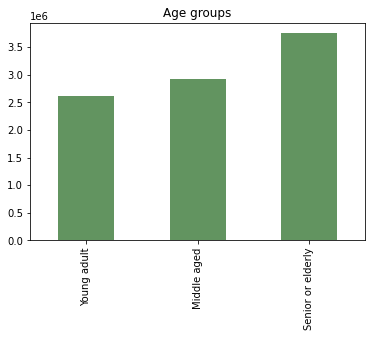

In [74]:
# Create a bar chart displaying the Age Profile
age_bar = df_current['age_group'].value_counts().loc[['Young adult', 'Middle aged', 'Senior or elderly']].plot.bar(color='#629460')
plt.title('Age groups')
plt.show()

#### The age group with the highest amount of customers are senior or elderly, with an age range of 56 and older.

- Between 18 and 35 = Young adult
- Between 36 and 55 = Middle aged
- Greater than 55 = Senior or elderly 

### Income profile

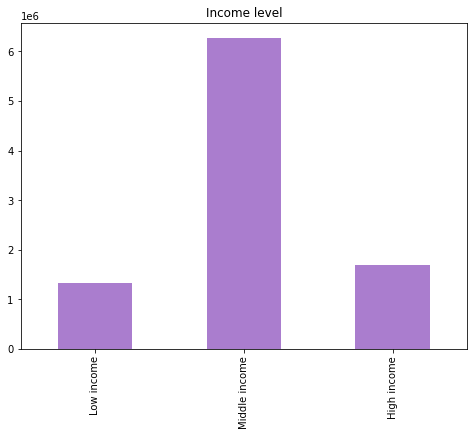

In [75]:
# Create a bar chart displaying the Income Profile
income_bar = df_current['income_level'].value_counts().loc[['Low income', 'Middle income', 'High income']].plot.bar(figsize = [8,6], color='#AA7DCE')
plt.title('Income level')
plt.show()

#### The majority of the customers earn a middle income, with salaries ranging from 55,001 to 140,000.

- Less than or equal to 55,000 = Low Income
- Between 55,001 and 140,000 inclusive = Middle income
- Above 140,000 = High income

### Number of dependents profile

<AxesSubplot:>

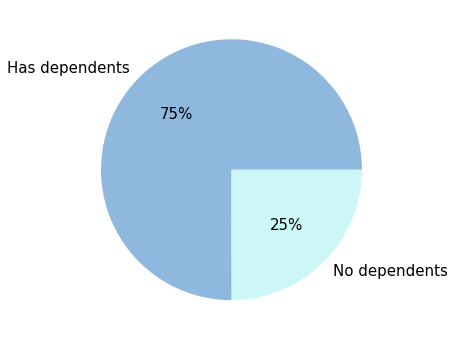

In [76]:
# Create a pie chart displaying the Number of Dependents Profile
dep_pie = df_current['has_dependents'].value_counts()
dependent_pie = dep_pie.plot.pie(label = '', labels = ['Has dependents', 'No dependents'], autopct=('%1.f%%'), colors=['#8FB8DE', '#CDF7F6'], textprops={'fontsize': 15}, figsize=[8,6])
dependent_pie

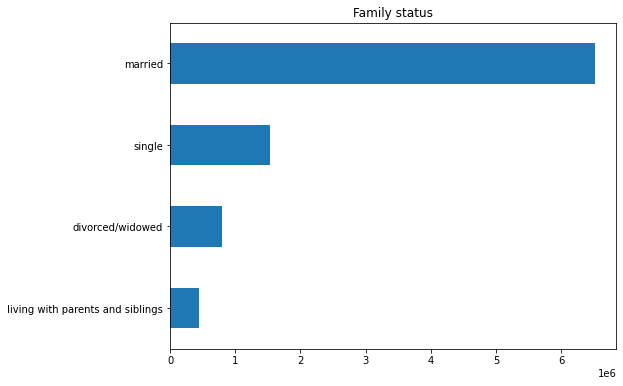

In [77]:
# Create a horizontal bar chart for family status 
status_bar = df_current['fam_status'].value_counts().sort_values().plot.barh(figsize = [8,6])
plt.title('Family status')
plt.show()

#### The most purchases were made by customers who are married.

### Brand loyalty and types of customers

<AxesSubplot:>

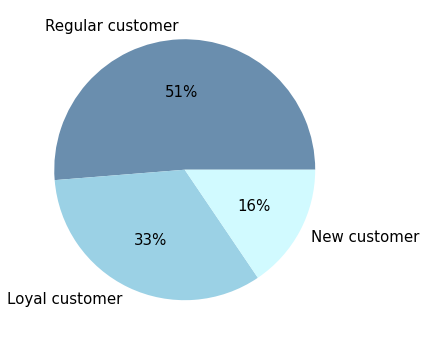

In [78]:
# Create a pie chart based on loyalty status
loyal = df_current['loyalty_flag'].value_counts()
loyal_status = loyal.plot.pie(label='', labels=['Regular customer', 'Loyal customer', 'New customer'],autopct=('%1.f%%'), colors=['#6A8EAE', '#9BD1E5', '#D1FAFF'], textprops={'fontsize': 15}, figsize =[8, 6])
loyal_status

In [79]:
df_current.groupby('loyalty_flag').agg({'median_last_order': ['min', 'max', 'mean']})

median_last_order                 
                               min   max       mean
loyalty_flag                                       
Loyal customer                 0.0  14.0   5.169604
New customer                   0.0  30.0  18.027044
Regular customer               0.0  30.0  10.613464

In [80]:
df_current.groupby('loyalty_flag').agg({'prices': ['min', 'max', 'mean']})

prices                
                    min   max      mean
loyalty_flag                           
Loyal customer      1.0  25.0  7.768915
New customer        1.0  25.0  7.801460
Regular customer    1.0  25.0  7.798146

<AxesSubplot:>

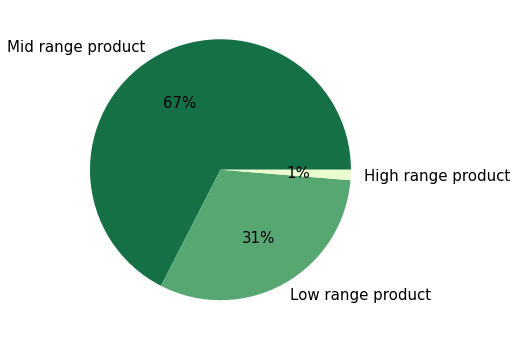

In [81]:
# Create a pie chart for the different price products 
price_category = df_current['prices_range_label'].value_counts()
price_ranges = price_category.plot.pie(label='', labels=['Mid range product', 'Low range product', 'High range product'],autopct=('%1.f%%'), colors=['#157145', '#57A773', '#EAFDCF'], textprops={'fontsize': 15}, figsize =[8, 6])
price_ranges

### Ordering habits based on types of customers

In [82]:
# Create a crosstab of the loyalty_flag and how much customers spend
df_loyalty_price = pd.crosstab(index=df_current['prices_range_label'], columns=df_current['loyalty_flag'], normalize = "index")

In [83]:
# Create a crosstab to display the labels
df_loyalty_price_label = pd.crosstab(index=df_current['prices_range_label'], columns=df_current['loyalty_flag'])

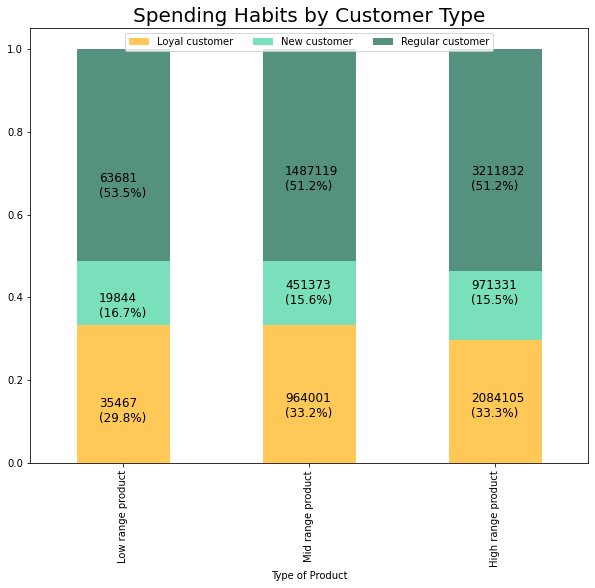

In [84]:
# Create a stacked bar chart for price range and types of customers
loyalty_price_sbar = df_loyalty_price.loc[['Low range product', 'Mid range product', 'High range product']].plot(kind='bar', stacked=True, color=['#FFC857', '#7ADFBB', '#55917F'], figsize=[10,8])

plt.title('Spending Habits by Customer Type', fontsize=20)
plt.legend(loc="upper center", ncol=3)
plt.xlabel("Type of Product")

for n, y in enumerate([*df_loyalty_price_label.index.values]):
    for (proportion, count, x_loc) in zip(df_loyalty_price.loc[y],
                                         df_loyalty_price_label.loc[y],
                                          df_loyalty_price.loc[y].cumsum()):
        
        plt.text(y=(x_loc - proportion) + (proportion / 3),
                 x=n - 0.13,
                 s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                 color="black",
                 fontsize=12)
        
plt.show()

### Ordering habits based on a customer's region

In [85]:
# Create a crosstab for region and type of customer
loyalty_region = pd.crosstab(index=df_current['region'], columns=df_current['loyalty_flag'], normalize="index")

In [86]:
# Create a crosstab to display labels
loyalty_region_labels = pd.crosstab(index=df_current['region'], columns=df_current['loyalty_flag'])

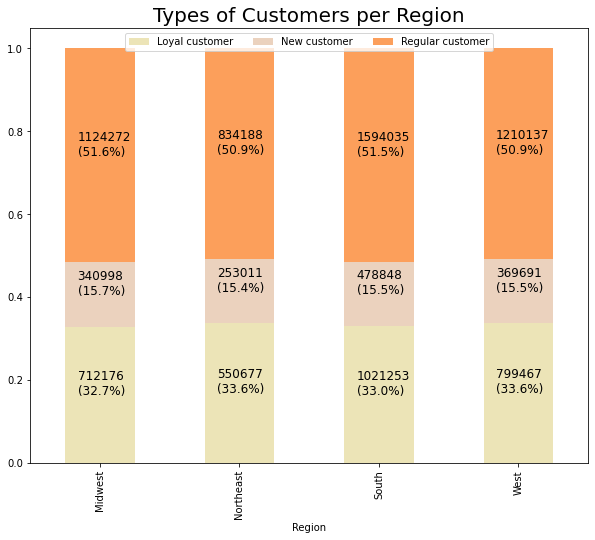

In [87]:
# Create a stacked bar chart for region and types of customers
loyalty_region_sbar = loyalty_region.plot(kind='bar', stacked=True, color=['#ECE4B7', '#EBD2BE', '#FC9F5B'], figsize=[10,8])
  
plt.title('Types of Customers per Region', fontsize=20)
plt.legend(loc="upper center", ncol=3)
plt.xlabel("Region")

for n, y in enumerate([*loyalty_region_labels.index.values]):
    for (proportion, count, x_loc) in zip(loyalty_region.loc[y],
                                         loyalty_region_labels.loc[y],
                                          loyalty_region.loc[y].cumsum()):
        
        plt.text(y=(x_loc - proportion) + (proportion / 2),
                 x=n - 0.16,
                 s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                 color="black",
                 fontsize=12)
        
plt.show()

In [88]:
# Create a crosstab for region and price range
region_price = pd.crosstab(index=df_current['region'], columns=df_current['prices_range_label'], normalize="index")

In [89]:
# Create a crosstab to display labels
region_price_labels = pd.crosstab(index=df_current['region'], columns=df_current['prices_range_label'])

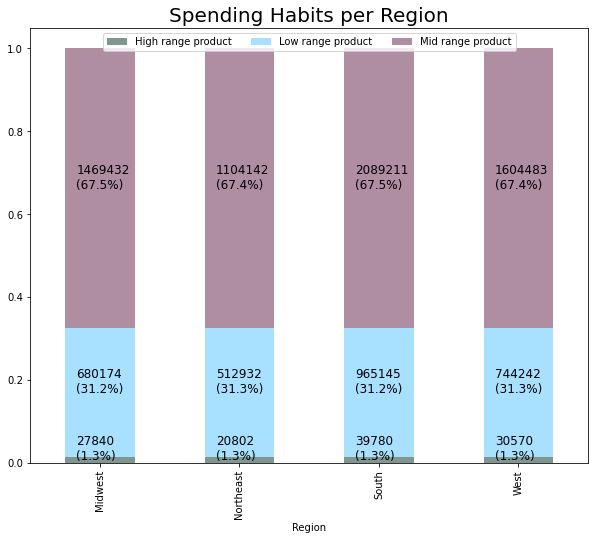

In [90]:
# Create a stacked bar chart for region and price range
region_price_sbar = region_price.plot(kind='bar', stacked=True, color=['#81968F', '#A8E0FF', '#B08EA2'], figsize=[10,8])

plt.title('Spending Habits per Region', fontsize=20)
plt.legend(loc="upper center", ncol=3)
plt.xlabel("Region")

for n, y in enumerate([*region_price_labels.index.values]):
    for (proportion, count, x_loc) in zip(region_price.loc[y],
                                         region_price_labels.loc[y],
                                          region_price.loc[y].cumsum()):
        
        plt.text(y=(x_loc - proportion) + (proportion / 2),
                 x=n - 0.17,
                 s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                 color="black",
                 fontsize=12)
        
plt.show()

### Ordering habits based on age and family status

In [91]:
# Create a crosstab for age group and order frequency
age_frequency = pd.crosstab(index=df_current['age_group'], columns=df_current['order_frequency_flag'], normalize="index")

In [92]:
# Create a crosstab to display labels
age_frequency_labels = pd.crosstab(index=df_current['age_group'], columns=df_current['order_frequency_flag'])

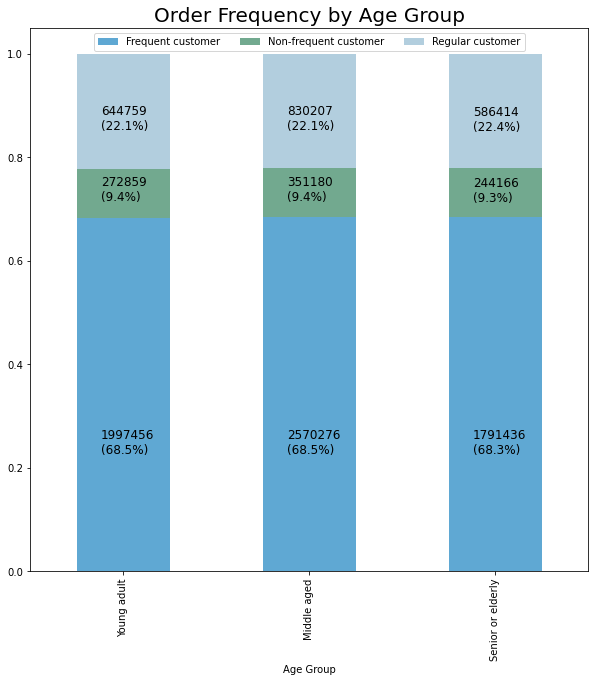

In [93]:
# Create a stacked bar chart for age group and order frequency
age_frequency_sbar = age_frequency.loc[['Young adult', 'Middle aged', 'Senior or elderly']].plot(kind='bar', stacked=True, color=['#5FA8D3', '#72A98F', '#B2CEDE'], figsize=[10, 10])

plt.title('Order Frequency by Age Group', fontsize=20)
plt.legend(loc="upper center", ncol=3)
plt.xlabel("Age Group")

for n, y in enumerate([*age_frequency_labels.index.values]):
    for (proportion, count, x_loc) in zip(age_frequency.loc[y],
                                         age_frequency_labels.loc[y],
                                          age_frequency.loc[y].cumsum()):
        
        plt.text(y=(x_loc - proportion) + (proportion / 3),
                 x=n - 0.12,
                 s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                 color="black",
                 fontsize=12)
        
plt.show()

In [94]:
# Create a crosstab for age group and price range
age_price_frequency = pd.crosstab(index=df_current['age_group'], columns=df_current['prices_range_label'], normalize="index")

In [95]:
# Create a crosstab to display labels
age_price_labels = pd.crosstab(index=df_current['age_group'], columns=df_current['prices_range_label'])

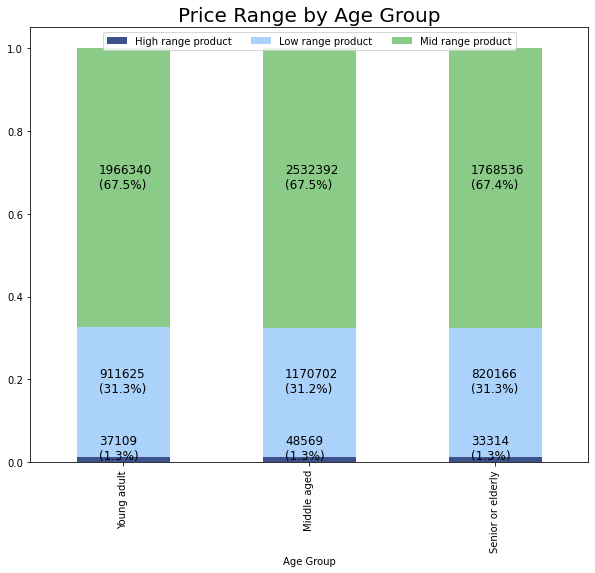

In [96]:
# Create a stacked bar chart for age group and price range
age_price_sbar = age_price_frequency.loc[['Young adult', 'Middle aged', 'Senior or elderly']].plot(kind='bar', stacked=True, color=['#3D518C', '#ABD2FA', '#8ACB88'], figsize=[10,8])

plt.title('Price Range by Age Group', fontsize=20)
plt.legend(loc="upper center", ncol=3)
plt.xlabel("Age Group") 

for n, y in enumerate([*age_price_labels.index.values]):
    for (proportion, count, x_loc) in zip(age_price_frequency.loc[y],
                                         age_price_labels.loc[y],
                                          age_price_frequency.loc[y].cumsum()):
        
        plt.text(y=(x_loc - proportion) + (proportion / 2),
                 x=n - 0.13,
                 s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                 color="black",
                 fontsize=12)
        
plt.show()

In [97]:
# Create a crosstab for family status and order frequency
fam_status_frequency = pd.crosstab(index=df_current['fam_status'], columns=df_current['order_frequency_flag'], normalize="index")

In [98]:
# Create a crosstab to display labels
fam_status_labels = pd.crosstab(index=df_current['fam_status'], columns=df_current['order_frequency_flag'])

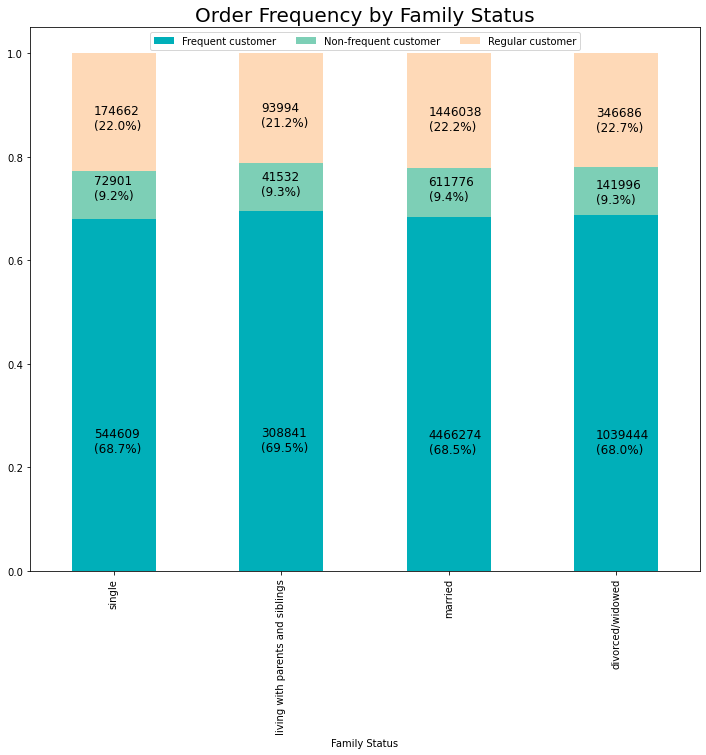

In [99]:
# Create a stacked bar chart for age group and order frequency
fam_status_frequency_sbar = fam_status_frequency.loc[['single', 'living with parents and siblings', 'married', 'divorced/widowed']].plot(kind='bar', stacked=True, color=['#00AFB9', '#7DCFB6', '#FED9B7'], figsize=[12, 10])

plt.title('Order Frequency by Family Status', fontsize=20)
plt.legend(loc="upper center", ncol=3)
plt.xlabel("Family Status")

for n, y in enumerate([*fam_status_labels.index.values]):
    for (proportion, count, x_loc) in zip(fam_status_frequency.loc[y],
                                          fam_status_labels.loc[y],
                                          fam_status_frequency.loc[y].cumsum()):
        
        plt.text(y=(x_loc - proportion) + (proportion / 3),
                 x=n - 0.12,
                 s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                 color="black",
                 fontsize=12)
        
plt.show()

In [100]:
# Create a crosstab for family status and price range
fam_status_price_frequency = pd.crosstab(index=df_current['fam_status'], columns=df_current['prices_range_label'], normalize="index")

In [101]:
# Create a crosstab to display labels
fam_status_price_labels = pd.crosstab(index=df_current['fam_status'], columns=df_current['prices_range_label'])

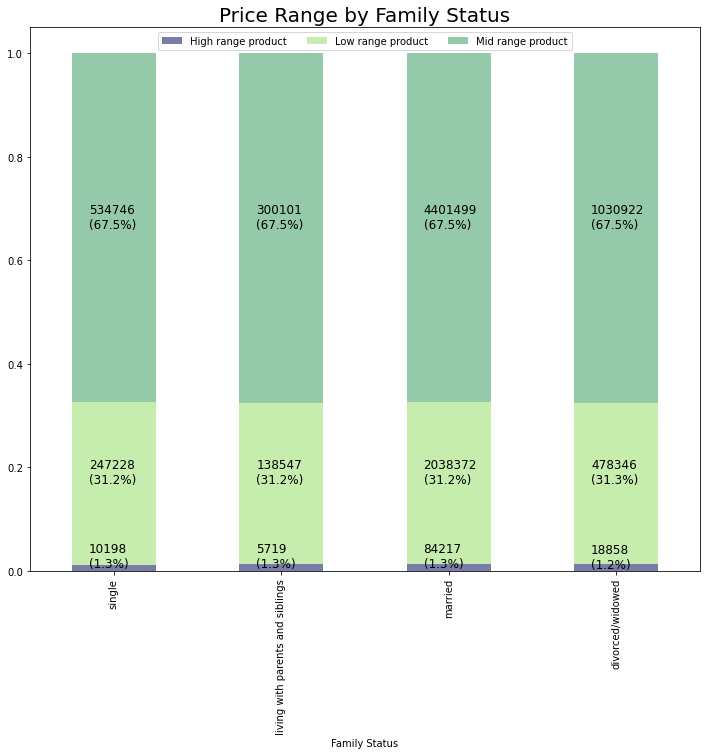

In [102]:
# Create a stacked bar chart for age group and price range
fam_status_price_sbar = fam_status_price_frequency.loc[['single', 'living with parents and siblings', 'married', 'divorced/widowed']].plot(kind='bar', stacked=True, color=['#777DA7', '#C6ECAE', '#94C9A9'], figsize=[12,10])

plt.title('Price Range by Family Status', fontsize=20)
plt.legend(loc="upper center", ncol=3)
plt.xlabel("Family Status") 

for n, y in enumerate([*fam_status_price_labels.index.values]):
    for (proportion, count, x_loc) in zip(fam_status_price_frequency.loc[y],
                                         fam_status_price_labels.loc[y],
                                          fam_status_price_frequency.loc[y].cumsum()):
        
        plt.text(y=(x_loc - proportion) + (proportion / 2),
                 x=n - 0.15,
                 s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                 color="black",
                 fontsize=12)
        
plt.show()

### Different classifications based on demographic information

In [103]:
# Create a crosstab for age group and region
age_region = pd.crosstab(index=df_current['region'], columns=df_current['age_group'], normalize="index")

In [104]:
# Create a crosstab to display labels
age_region_labels = pd.crosstab(index=df_current['region'], columns=df_current['age_group'])

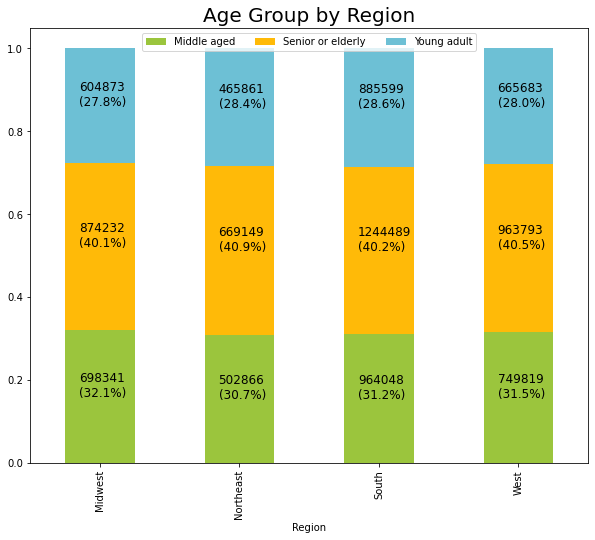

In [105]:
# Create a stacked bar chart for age group and region
age_region_sbar = age_region.plot(kind='bar', stacked=True, color=['#9BC53D', '#FFBA08', '#6DC0D5'], figsize=[10,8])

plt.title('Age Group by Region', fontsize=20)
plt.legend(loc="upper center", ncol=4)
plt.xlabel("Region")

for n, y in enumerate([*age_region_labels.index.values]):
    for (proportion, count, x_loc) in zip(age_region.loc[y],
                                         age_region_labels.loc[y],
                                          age_region.loc[y].cumsum()):
        
        plt.text(y=(x_loc - proportion) + (proportion / 2),
                 x=n - 0.15,
                 s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                 color="black",
                 fontsize=12)
        
plt.show()

In [106]:
# Create a crosstab for income level and region
income_level_region = pd.crosstab(index=df_current['region'], columns=df_current['income_level'], normalize="index")

In [107]:
# Create a crosstab to display labels
income_level_region_labels = pd.crosstab(index=df_current['region'], columns=df_current['income_level'])

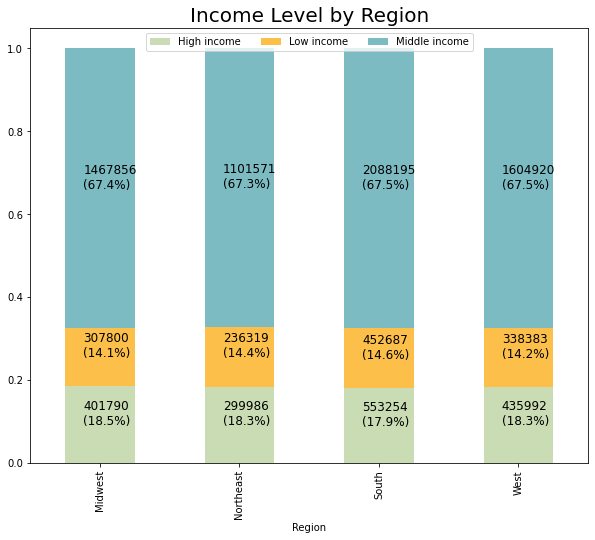

In [108]:
# Create a stacked bar chart for income level and region
income_region_sbar = income_level_region.plot(kind='bar', stacked=True, color=['#C9DCB3', '#FCBF49', '#7DBBC3'], figsize=[10,8])

plt.title('Income Level by Region', fontsize=20)
plt.legend(loc="upper center", ncol=3)
plt.xlabel("Region")

for n, y in enumerate([*income_level_region_labels.index.values]):
    for (proportion, count, x_loc) in zip(income_level_region.loc[y],
                                         income_level_region_labels.loc[y],
                                          income_level_region.loc[y].cumsum()):
        
        plt.text(y=(x_loc - proportion) + (proportion / 2),
                 x=n - 0.12,
                 s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                 color="black",
                 fontsize=12)
        
plt.show()

In [109]:
# Create a crosstab for family status and region
family_region = pd.crosstab(index=df_current['region'], columns=df_current['fam_status'], normalize="index")

In [110]:
# Create a crosstab to display labels
family_region_labels = pd.crosstab(index=df_current['region'], columns=df_current['fam_status'])

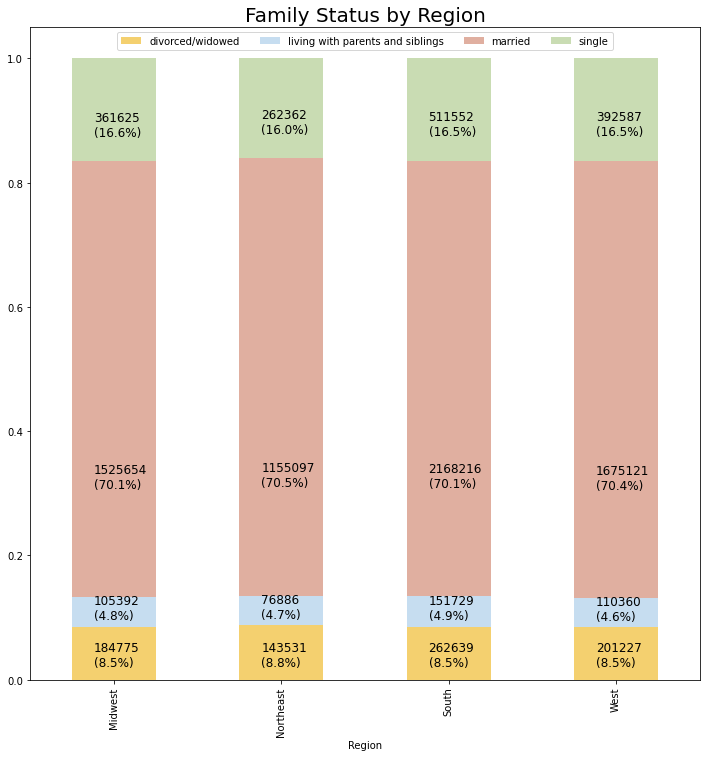

In [111]:
# Create a stacked bar chart for family status and region
family_region_sbar = family_region.plot(kind='bar', stacked=True, color=['#F4D06F', '#C6DDF0', '#E0AFA0', '#C9DCB3'], figsize=[12,12])

plt.title('Family Status by Region', fontsize=20)
plt.legend(loc="upper center", ncol=4)
plt.xlabel("Region")

for n, y in enumerate([*family_region_labels.index.values]):
    for (proportion, count, x_loc) in zip(family_region.loc[y],
                                         family_region_labels.loc[y],
                                          family_region.loc[y].cumsum()):
        
        plt.text(y=(x_loc - proportion) + (proportion / 4),
                 x=n - 0.12,
                 s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                 color="black",
                 fontsize=12)
        
plt.show()

### Ordering habits based on different customer profiles

In [112]:
df_current['pet_owners'].value_counts(dropna = False)

0    8586744
1     702009
Name: pet_owners, dtype: int64

Text(0.5, 1.0, 'Pet Products (sales profile)')

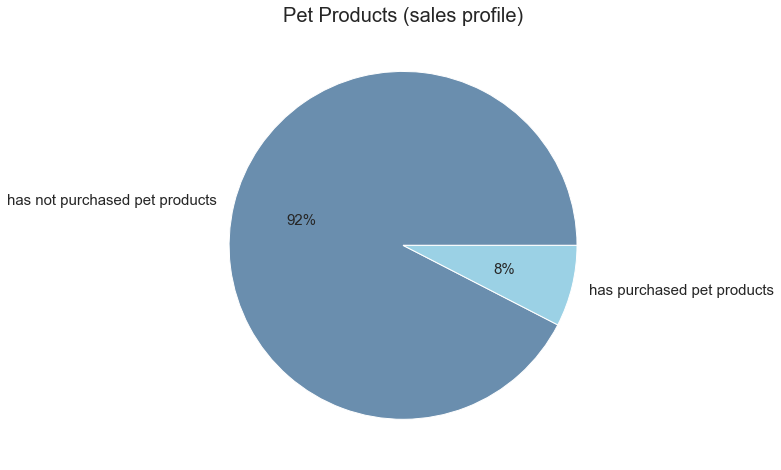

In [113]:
# Create a pie chart for the pet owners profile
sns.set(rc = {'figure.figsize':(10,8)})
pet_pie = df_current['pet_owners'].value_counts().plot.pie(label='', labels=['has not purchased pet products', 'has purchased pet products'],autopct=('%1.f%%'), colors=['#6A8EAE', '#9BD1E5'], textprops = {'fontsize': 15})
plt.title('Pet Products (sales profile)', fontdict = {'fontsize': 20})

In [114]:
df_current['baby_status'].value_counts(dropna = False)

0    7023318
1    2265435
Name: baby_status, dtype: int64

Text(0.5, 1.0, 'Baby Products (sales profile)')

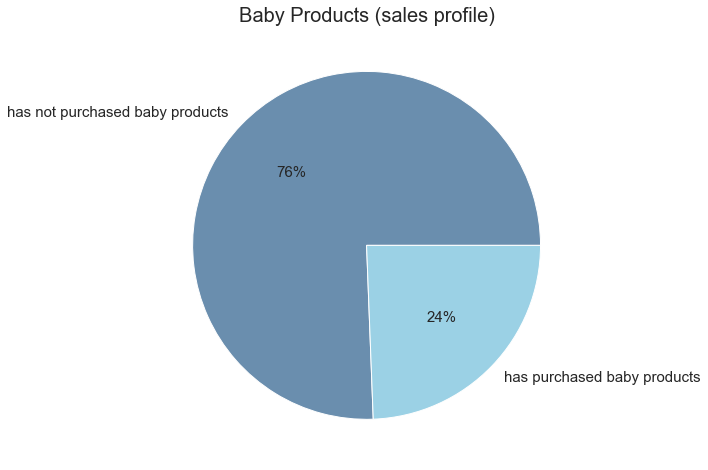

In [115]:
# Create a pie chart for the new parents profile
new_parents = df_current['baby_status'].value_counts().plot.pie(label='', labels=['has not purchased baby products', 'has purchased baby products'],autopct=('%1.f%%'), colors=['#6A8EAE', '#9BD1E5'], textprops = {'fontsize': 15})
plt.title('Baby Products (sales profile)', fontdict = {'fontsize': 20})

In [116]:
df_current['alcohol_status'].value_counts(dropna = False)

0    8758198
1     530555
Name: alcohol_status, dtype: int64

Text(0.5, 1.0, 'Alcoholic Beverages (sales profile)')

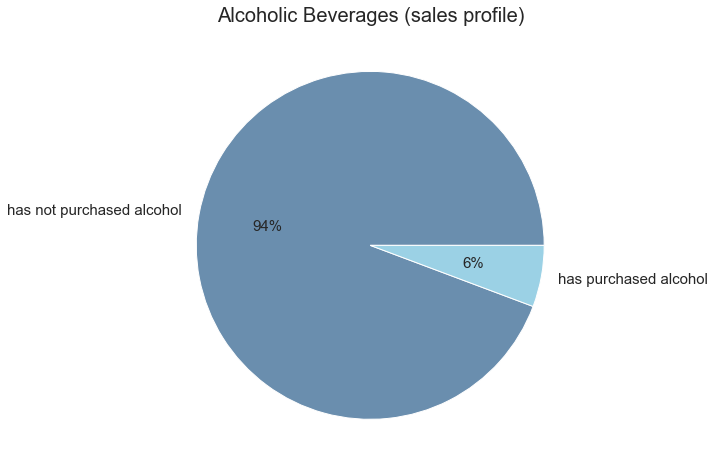

In [117]:
# Create a pie chart for the alcohol status profile
alcohol_drinker = df_current['alcohol_status'].value_counts().plot.pie(label='', labels=['has not purchased alcohol', 'has purchased alcohol'],autopct=('%1.f%%'), colors=['#6A8EAE', '#9BD1E5'], textprops = {'fontsize': 15})
plt.title('Alcoholic Beverages (sales profile)', fontdict = {'fontsize': 20})

# 08. Export the visualizations

In [118]:
# Export the final dataset
df_current.to_pickle(os.path.join (path, '02 Data', 'Prepared Data', 'final_instacart_dataset.pkl'))

In [119]:
# Export the order_hod_hist 
order_hod_hist.figure.savefig((os.path.join (path, '04 Analysis', 'Visualizations', 'order_hod_hist.png')))

In [140]:
# Export the hour_price_line line chart
hour_price_line.figure.savefig(os.path.join (path, '04 Analysis', 'Visualizations', 'hour_price_line.png'))

In [120]:
# Export the order_dow bar chart
order_dow_bar.figure.savefig(os.path.join (path, '04 Analysis', 'Visualizations', 'order_dow_bar_chart.png'))

In [121]:
# Export the category_purchases horizontal bar chart
dept_bar.figure.savefig(os.path.join (path, '04 Analysis', 'Visualizations', 'departmental_hbar_chart.png'))

In [122]:
# Export the age_group bar chart
age_bar.figure.savefig(os.path.join (path, '04 Analysis', 'Visualizations', 'age_group_bar_chart.png'))

In [123]:
# Export the income_level bar chart
income_bar.figure.savefig(os.path.join (path, '04 Analysis', 'Visualizations', 'income_level_bar_chart.png'))

In [124]:
# Export the has_dependents pie chart
dependent_pie.figure.savefig(os.path.join (path, '04 Analysis', 'Visualizations', 'dependents_pie_chart.png'))

In [125]:
# Export the family status horizontal bar chart
status_bar.figure.savefig(os.path.join (path, '04 Analysis', 'Visualizations', 'fam_status_hbar_chart.png'))

In [126]:
# Export the loyal customers pie chart
loyal_status.figure.savefig(os.path.join (path, '04 Analysis', 'Visualizations', 'loyal_status_pie_chart.png'))

In [127]:
# Export the product range pie chart
price_ranges.figure.savefig(os.path.join (path, '04 Analysis', 'Visualizations', 'price_range_pie_chart.png'))

In [128]:
# Export the price and customer stacked bar chart
loyalty_price_sbar.figure.savefig(os.path.join (path, '04 Analysis', 'Visualizations', 'price_customer_sbar.png'))

In [129]:
# Export the region and customer stacked bar chart
loyalty_region_sbar.figure.savefig(os.path.join (path, '04 Analysis', 'Visualizations', 'region_customer_sbar.png'))

In [130]:
# Export the age group and order frequency stacked bar chart
age_frequency_sbar.figure.savefig(os.path.join (path, '04 Analysis', 'Visualizations', 'age_frequency_sbar.png'))

In [131]:
# Export the age group and price range stacked bar chart
age_price_sbar.figure.savefig(os.path.join (path, '04 Analysis', 'Visualizations', 'age_price_sbar.png'))

In [132]:
# Export the family status and order frequency stacked bar chart
fam_status_frequency_sbar.figure.savefig(os.path.join (path, '04 Analysis', 'Visualizations', 'fam_status_frequency_sbar.png'))

In [133]:
# Export the family status and price range stacked bar chart
fam_status_price_sbar.figure.savefig(os.path.join (path, '04 Analysis', 'Visualizations', 'fam_status_price_sbar.png'))

In [134]:
# Export the age group and region stacked bar chart
age_region_sbar.figure.savefig(os.path.join (path, '04 Analysis', 'Visualizations', 'age_region_sbar.png'))

In [135]:
# Export the income level and region stacked bar chart
income_region_sbar.figure.savefig(os.path.join (path, '04 Analysis', 'Visualizations', 'income_region_sbar.png'))

In [136]:
# Export the family status and region stacked bar chart
family_region_sbar.figure.savefig(os.path.join (path, '04 Analysis', 'Visualizations', 'family_region_sbar.png'))

In [137]:
# Export the pet owners pie chart
pet_pie.figure.savefig(os.path.join (path, '04 Analysis', 'Visualizations', 'pet_owners_pie.png'))

In [138]:
# Export the baby status pie chart
new_parents.figure.savefig(os.path.join (path, '04 Analysis', 'Visualizations', 'new_parents_pie.png'))

In [139]:
# Export the baby status pie chart
alcohol_drinker.figure.savefig(os.path.join (path, '04 Analysis', 'Visualizations', 'alcoholic_pie.png'))